### Concurso predicción compra casas

In [86]:
import mlflow
import mlflow.tensorflow
mlflow.tensorflow.autolog()
import plotly.io as pio

In [2]:
import mlflow.keras
import os
from getpass import getpass

#vinculamos la cuenta de dagshub con mlflow
os.environ['MLFLOW_TRACKING_USERNAME'] = "mseguracarrillo7"
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass("Enter your DAGsHub access token or password: ")
os.environ["MLFLOW_TRACKING_URI"]="https://dagshub.com/mseguracarrillo7/Prediccion_CompraC"
mlflow.set_tracking_uri("https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow")

Enter your DAGsHub access token or password:  ········


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import optuna 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [7]:
data= pd.DataFrame(pd.read_csv("global_house_purchase_dataset.csv"))

In [9]:
data.shape

(200000, 25)

In [11]:
data.head(10)

,property_id,country,city,property_type,furnishing_status,property_size_sqft,price,constructed_year,previous_owners,rooms,...,customer_salary,loan_amount,loan_tenure_years,monthly_expenses,down_payment,emi_to_income_ratio,satisfaction_score,neighbourhood_rating,connectivity_score,decision
0,1,France,Marseille,Farmhouse,Semi-Furnished,991,412935,1989,6,6,...,10745,193949,15,6545,218986,0.16,1,5,6,0
1,2,South Africa,Cape Town,Apartment,Semi-Furnished,1244,224538,1990,4,8,...,16970,181465,20,8605,43073,0.08,9,1,2,0
2,3,South Africa,Johannesburg,Farmhouse,Semi-Furnished,4152,745104,2019,5,2,...,21914,307953,30,2510,437151,0.09,6,8,1,0
3,4,Germany,Frankfurt,Farmhouse,Semi-Furnished,3714,1110959,2008,1,3,...,17980,674720,15,8805,436239,0.33,2,6,6,0
4,5,South Africa,Johannesburg,Townhouse,Fully-Furnished,531,99041,2007,6,3,...,17676,65833,25,8965,33208,0.03,3,3,4,0
5,6,Canada,Montreal,Villa,Semi-Furnished,3169,1107368,1985,0,5,...,95520,793316,30,10615,314052,0.05,10,8,2,1
6,7,Brazil,Rio de Janeiro,Studio,Unfurnished,1986,398439,1976,1,2,...,11426,268167,25,14440,130272,0.16,9,10,10,1
7,8,Brazil,São Paulo,Townhouse,Semi-Furnished,4048,807236,2020,4,6,...,29832,503385,20,7200,303851,0.13,1,5,8,0
8,9,UAE,Dubai,Farmhouse,Semi-Furnished,5213,3131373,1968,6,2,...,56255,1866416,15,10300,1264957,0.29,8,8,10,1
9,10,Australia,Melbourne,Apartment,Unfurnished,4648,1483250,1966,2,5,...,67350,1093290,10,16360,389960,0.18,1,4,7,0


La base de datos contempla columnas que indican unidades monetarias según el país en donde se encuentra la casa, entonces podemos convertirlo a unidades USD.

In [13]:
paises_unicos = data['country'].unique() #países en la base de datos 

print("Los países en el dataset son:")
print(paises_unicos)

Los países en el dataset son:
['France' 'South Africa' 'Germany' 'Canada' 'Brazil' 'UAE' 'Australia'
 'UK' 'USA' 'China' 'Singapore' 'India' 'Japan']


In [15]:
# Tasas de conversión aproximadas a USD (Octubre 2025)
# 1 Moneda Local = X Dólares USD
rates_to_usd = {
    'France': 1.08,        # Euro (EUR)
    'South Africa': 0.053,   # Rand (ZAR)
    'Germany': 1.08,       # Euro (EUR)
    'Canada': 0.73,        # Dólar Canadiense (CAD)
    'Brazil': 0.18,        # Real Brasileño (BRL)
    'UAE': 0.27,           # Dírham de los EAU (AED)
    'Australia': 0.66,     # Dólar Australiano (AUD)
    'UK': 1.25,            # Libra Esterlina (GBP)
    'USA': 1.0,            # Dólar Estadounidense (USD)
    'China': 0.14,         # Yuan Chino (CNY)
    'Singapore': 0.74,     # Dólar de Singapur (SGD)
    'India': 0.012,        # Rupia India (INR)
    'Japan': 0.0064       # Yen Japonés (JPY)
}

In [17]:
data['price_USD'] = data.apply(
    lambda row: row['price'] * rates_to_usd.get(row['country'], 1.0), 
    axis=1
) #creamos una nueva columna de precio de la casa en la que aplicamos la conversión según el país 

#ahora haremos lo mismo para las columnas (customer_salary, loan_amount, monthly_expenses, down_payment )
data['customer_salary_USD'] = data.apply(
    lambda row: row['customer_salary'] * rates_to_usd.get(row['country'], 1.0), 
    axis=1
)

data['loan_amount_USD'] = data.apply(
    lambda row: row['loan_amount'] * rates_to_usd.get(row['country'], 1.0), 
    axis=1
)

data['monthly_expenses_USD'] = data.apply(
    lambda row: row['monthly_expenses'] * rates_to_usd.get(row['country'], 1.0), 
    axis=1
)

data['down_payment_USD'] = data.apply(
    lambda row: row['down_payment'] * rates_to_usd.get(row['country'], 1.0), 
    axis=1
)

#borramos las columnas iniciales 
data = data.drop(['price', 'customer_salary', 'loan_amount', 'monthly_expenses', 'down_payment'], axis=1)


In [19]:
data.head(10) #nuevo data con todo en unidades onetarias USD

,property_id,country,city,property_type,furnishing_status,property_size_sqft,constructed_year,previous_owners,rooms,bathrooms,...,emi_to_income_ratio,satisfaction_score,neighbourhood_rating,connectivity_score,decision,price_USD,customer_salary_USD,loan_amount_USD,monthly_expenses_USD,down_payment_USD
0,1,France,Marseille,Farmhouse,Semi-Furnished,991,1989,6,6,2,...,0.16,1,5,6,0,445969.800,11604.600,209464.920,7068.600,236504.880
1,2,South Africa,Cape Town,Apartment,Semi-Furnished,1244,1990,4,8,8,...,0.08,9,1,2,0,11900.514,899.410,9617.645,456.065,2282.869
2,3,South Africa,Johannesburg,Farmhouse,Semi-Furnished,4152,2019,5,2,1,...,0.09,6,8,1,0,39490.512,1161.442,16321.509,133.030,23169.003
3,4,Germany,Frankfurt,Farmhouse,Semi-Furnished,3714,2008,1,3,3,...,0.33,2,6,6,0,1199835.720,19418.400,728697.600,9509.400,471138.120
4,5,South Africa,Johannesburg,Townhouse,Fully-Furnished,531,2007,6,3,3,...,0.03,3,3,4,0,5249.173,936.828,3489.149,475.145,1760.024
5,6,Canada,Montreal,Villa,Semi-Furnished,3169,1985,0,5,2,...,0.05,10,8,2,1,808378.640,69729.600,579120.680,7748.950,229257.960
6,7,Brazil,Rio de Janeiro,Studio,Unfurnished,1986,1976,1,2,1,...,0.16,9,10,10,1,71719.020,2056.680,48270.060,2599.200,23448.960
7,8,Brazil,São Paulo,Townhouse,Semi-Furnished,4048,2020,4,6,6,...,0.13,1,5,8,0,145302.480,5369.760,90609.300,1296.000,54693.180
8,9,UAE,Dubai,Farmhouse,Semi-Furnished,5213,1968,6,2,1,...,0.29,8,8,10,1,845470.710,15188.850,503932.320,2781.000,341538.390
9,10,Australia,Melbourne,Apartment,Unfurnished,4648,1966,2,5,2,...,0.18,1,4,7,0,978945.000,44451.000,721571.400,10797.600,257373.600


In [21]:
x = data.drop("decision",axis=1)
#todas las columnas menos la decisión 

In [23]:
y = data['decision'] 
#salida, 0: no se compro, 1:se compró

In [25]:
y.head(10)

0    0
1    0
2    0
3    0
4    0
5    1
6    1
7    0
8    1
9    0
Name: decision, dtype: int64

In [27]:
data.isna().sum()
#no tenemos datos faltantes 

property_id                0
country                    0
city                       0
property_type              0
furnishing_status          0
property_size_sqft         0
constructed_year           0
previous_owners            0
rooms                      0
bathrooms                  0
garage                     0
garden                     0
crime_cases_reported       0
legal_cases_on_property    0
loan_tenure_years          0
emi_to_income_ratio        0
satisfaction_score         0
neighbourhood_rating       0
connectivity_score         0
decision                   0
price_USD                  0
customer_salary_USD        0
loan_amount_USD            0
monthly_expenses_USD       0
down_payment_USD           0
dtype: int64

Tenemos columnas que tienenvariables categóricas, podemos aplicar one-hot encouding para representarlas en 0 y 1.

In [29]:
x = pd.get_dummies(x, drop_first=True) 
# separa la columna de variables categóricas en otras columnas donde a cada variable se le asigne un cero o 1 según el dato

In [31]:
x.corr() #para observar las correlaciones entre las variables de predicción

,property_id,property_size_sqft,constructed_year,previous_owners,rooms,bathrooms,garage,garden,crime_cases_reported,legal_cases_on_property,...,city_Tokyo,city_Toronto,city_Vancouver,property_type_Farmhouse,property_type_Independent House,property_type_Studio,property_type_Townhouse,property_type_Villa,furnishing_status_Semi-Furnished,furnishing_status_Unfurnished
property_id,1.000000,-0.003263,0.000298,-0.001642,-0.003383,-0.001282,-0.000377,0.002687,0.001730,-0.000898,...,0.006202,-0.000371,-0.000893,-0.002139,0.000710,-0.000297,0.000488,0.002883,0.002658,-0.004103
property_size_sqft,-0.003263,1.000000,-0.005571,-0.000073,-0.001998,-0.000103,-0.001134,0.000752,0.000138,0.000780,...,-0.001146,-0.005465,-0.001977,-0.000589,0.000466,0.001511,-0.000229,-0.002309,-0.001152,0.000197
constructed_year,0.000298,-0.005571,1.000000,0.002102,-0.001644,0.002777,-0.002187,-0.004791,0.002410,-0.003041,...,-0.001942,0.001456,0.001141,-0.000174,0.001722,-0.002627,0.002406,-0.000534,0.001562,0.001012
previous_owners,-0.001642,-0.000073,0.002102,1.000000,-0.001797,-0.001252,0.000246,-0.000460,-0.000204,-0.000729,...,0.001287,0.001874,0.000029,0.000602,0.001617,0.002716,0.001040,-0.000802,0.002557,-0.001177
rooms,-0.003383,-0.001998,-0.001644,-0.001797,1.000000,0.626471,0.000533,-0.000151,0.000275,0.004449,...,-0.003396,0.002045,0.000181,0.000330,-0.000291,-0.000882,0.000501,-0.000704,0.000669,-0.004421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
property_type_Studio,-0.000297,0.001511,-0.002627,0.002716,-0.000882,0.005589,0.003864,-0.002777,-0.001102,0.000799,...,-0.000612,0.001221,-0.000199,-0.199488,-0.198830,1.000000,-0.199048,-0.198877,0.004580,-0.001568
property_type_Townhouse,0.000488,-0.000229,0.002406,0.001040,0.000501,0.001215,0.000837,-0.002646,0.001407,0.000413,...,-0.000529,0.000463,0.001141,-0.200887,-0.200224,-0.199048,1.000000,-0.200271,0.001629,-0.003344
property_type_Villa,0.002883,-0.002309,-0.000534,-0.000802,-0.000704,-0.002045,-0.003724,0.002370,-0.002893,-0.000178,...,0.005315,0.002103,-0.002121,-0.200714,-0.200052,-0.198877,-0.200271,1.000000,-0.002951,0.002063
furnishing_status_Semi-Furnished,0.002658,-0.001152,0.001562,0.002557,0.000669,-0.001887,0.003772,0.003546,0.000918,0.004238,...,-0.002702,0.003496,0.000610,0.000292,-0.005276,0.004580,0.001629,-0.002951,1.000000,-0.499087


In [31]:
x.shape

(200000, 78)

También podemos normalizar los datos numéricos para que las variables estén en la misma escala. 

$x_{scaled}$ = $\frac{x - mean(x)}{std(x)}$

In [33]:
scaler = StandardScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns) #aplicamos la normalizaciómn a las variables en x

Vamos a separar los datos de prueba, entrenamiento y validación:

In [35]:
x_train, x_Test, y_train, y_Test = train_test_split(x_scaled,y, train_size=0.7, random_state=123)
#dividimos con 70% de los datos a entrenamiento, semilla para que nos arroje los mismos conjuntos al corerr

Ahora subdividimos $Test$ en nuestros datos de prueba que usaremos en el modelo y en los de validación.

In [37]:
x_test, x_val, y_test, y_val = train_test_split(x_Test,y_Test, train_size=2/3, random_state=123)
#tomamos 2/3 partes del 30% = 20% para pruebas y el restante 10% para validación.

In [41]:
#creación del modelo
x_train = sm.add_constant(x_train, prepend=True)
modelo = sm.Logit(endog = y_train, exog = x_train)
modelo_fit = modelo.fit()
print(modelo_fit.summary())

         Current function value: 0.128491
         Iterations: 35


C:\Users\Moises\anaconda3\envs\tf_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:               decision   No. Observations:               140000
Model:                          Logit   Df Residuals:                   139934
Method:                           MLE   Df Model:                           65
Date:                Wed, 08 Oct 2025   Pseudo R-squ.:                  0.7622
Time:                        10:53:07   Log-Likelihood:                -17989.
converged:                      False   LL-Null:                       -75658.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              -13.8808   3.23e+05   -4.3e-05      1.000   -6.32e+05    6.32e+05
property_id                         -0.0084      0.013     -0.621

Podríamos eliminar algunas de nuestras variables ya que tienen un valor P alto, in embargo, vamos a construir nuestra red tomando en cuenta todas las variables.

#### Usaré optuna para búsqueda de mejores hiperparámetros

In [39]:
def create_model(trial):
    with mlflow.start_run(nested=True): 
        params= {
            "learning_rate": trial.suggest_float("learning_rate",1e-4, 1e-2, log=True),
            "n_layers": trial.suggest_int("n_layers",1,3),
            "dropout_rate": trial.suggest_float("dropout_rate", 0.1, 0.5),
            "optimizer": trial.suggest_categorical("optimizer", ["adam", "rmsprop", "sgd"])
        }

        mlflow.log_params(params)
        model = models.Sequential()
        model.add(tf.keras.layers.Input(shape=(x_train.shape[1],))) 
    
        for i in range (params["n_layers"]):
            n_units = trial.suggest_int(f"n_units_l{i}", 32, 256)
            model.add(layers.Dense(n_units, activation = 'relu'))
            model.add(tf.keras.layers.Dropout(params["dropout_rate"])) #aplicamos el dropout sugerido
            
            mlflow.log_param(f"n_units_l{i}", n_units)
        model.add(layers.Dense(1, activation='sigmoid'))

        lr = params["learning_rate"]
        optimizer_selected = params["optimizer"]

        if optimizer_selected == "adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
        elif optimizer_selected == "sgd":
            optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        elif optimizer_selected == "rmsprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr)

    #usaremos binary cross entropy porque solo tenemos dos pposibles salidas (compro, no compro)
        model.compile(optimizer = optimizer,
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"])
    return model 

mlflow.keras.autolog()

In [41]:
def objective(trial):
    modelo= create_model(trial)
    history= modelo.fit(x_train, y_train, epochs=5, batch_size=64, verbose=0)
    loss, accuracy = modelo.evaluate(x_test, y_test, verbose=0)
    mlflow.log_metric("accuracy", accuracy)
    return accuracy 

Ahora, hacemos las pruebas y con ello buscaremos seleccionar la mejor o los mejores parámetros para después generar nuestro modelo final.

In [43]:
#prueba 01
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials=30)

[I 2025-10-08 11:34:28,690] A new study created in memory with name: no-name-93610157-4106-4909-b2a9-1c1c6ee712a9


🏃 View run merciful-zebra-827 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/ad37b63544f44c8c945c74aa940d015f
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:34:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7c990d6e188a452b8ce1a0537671a4c2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


🏃 View run sincere-hawk-209 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/7c990d6e188a452b8ce1a0537671a4c2
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:35:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:35:33,180] Trial 0 finished with value: 0.99795001745224 and parameters: {'learning_rate': 0.00026794856524171823, 'n_layers': 3, 'dropout_rate': 0.17155996419583552, 'optimizer': 'adam', 'n_units_l0': 213, 'n_units_l1': 67, 'n_units_l2': 119}. Best is trial 0 with value: 0.99795001745224.


🏃 View run mercurial-slug-603 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/a2bdc7d4375a4471b15c1fb5490376f5
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:36:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:36:32,448] Trial 1 finished with value: 0.9979249835014343 and parameters: {'learning_rate': 0.002037505798867842, 'n_layers': 3, 'dropout_rate': 0.1853910185050377, 'optimizer': 'rmsprop', 'n_units_l0': 209, 'n_units_l1': 123, 'n_units_l2': 113}. Best is trial 0 with value: 0.99795001745224.


🏃 View run mercurial-lark-440 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/21eaa7aca60f467ea43fc4a0c501fea6
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:37:31,142] Trial 2 finished with value: 0.7704499959945679 and parameters: {'learning_rate': 0.00040526544073286793, 'n_layers': 3, 'dropout_rate': 0.2186343710386087, 'optimizer': 'sgd', 'n_units_l0': 171, 'n_units_l1': 74, 'n_units_l2': 226}. Best is trial 0 with value: 0.99795001745224.


🏃 View run abundant-horse-882 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/ab67bfb7684748748b0a9421efa48672
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:38:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:38:29,301] Trial 3 finished with value: 0.9975000023841858 and parameters: {'learning_rate': 0.00438254423819614, 'n_layers': 2, 'dropout_rate': 0.1604328738214592, 'optimizer': 'rmsprop', 'n_units_l0': 236, 'n_units_l1': 165}. Best is trial 0 with value: 0.99795001745224.


🏃 View run trusting-tern-238 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/cf03c7098a88469eab97b31b56e3b1b4
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:39:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:39:29,518] Trial 4 finished with value: 0.8758249878883362 and parameters: {'learning_rate': 0.0006924549472118018, 'n_layers': 1, 'dropout_rate': 0.3762204106563889, 'optimizer': 'sgd', 'n_units_l0': 219}. Best is trial 0 with value: 0.99795001745224.


🏃 View run ambitious-stag-46 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/288557fa074a4410b874d0ab99f9f673
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:40:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:40:28,714] Trial 5 finished with value: 0.9973999857902527 and parameters: {'learning_rate': 0.00174751299420102, 'n_layers': 2, 'dropout_rate': 0.43581826373870713, 'optimizer': 'rmsprop', 'n_units_l0': 149, 'n_units_l1': 91}. Best is trial 0 with value: 0.99795001745224.


🏃 View run silent-lynx-606 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/6a51316e706e4fa980f13bbc553e6abd
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:41:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:41:24,514] Trial 6 finished with value: 0.9551249742507935 and parameters: {'learning_rate': 0.009074557529007328, 'n_layers': 2, 'dropout_rate': 0.359318884359105, 'optimizer': 'sgd', 'n_units_l0': 115, 'n_units_l1': 149}. Best is trial 0 with value: 0.99795001745224.


🏃 View run youthful-sheep-906 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/72001584a7ad41bc861736a043871342
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:42:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:42:08,011] Trial 7 finished with value: 0.7884500026702881 and parameters: {'learning_rate': 0.0004174241049659263, 'n_layers': 1, 'dropout_rate': 0.21151487972429842, 'optimizer': 'sgd', 'n_units_l0': 39}. Best is trial 0 with value: 0.99795001745224.


🏃 View run gregarious-bass-696 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/0dce7073412d4d7e9cdd276a7a795760
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:42:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:43:08,760] Trial 8 finished with value: 0.7784249782562256 and parameters: {'learning_rate': 0.0001458149824208219, 'n_layers': 1, 'dropout_rate': 0.4536917887940215, 'optimizer': 'sgd', 'n_units_l0': 212}. Best is trial 0 with value: 0.99795001745224.


🏃 View run resilient-tern-254 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/2957726549b94fa2bb87c93b210d9a74
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:43:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:44:04,772] Trial 9 finished with value: 0.9508500099182129 and parameters: {'learning_rate': 0.006944298961404885, 'n_layers': 1, 'dropout_rate': 0.3651645677223573, 'optimizer': 'sgd', 'n_units_l0': 32}. Best is trial 0 with value: 0.99795001745224.


🏃 View run exultant-sloth-42 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/cffa081c7baa4f54a3d842845418d949
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:45:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:45:06,933] Trial 10 finished with value: 0.9924250245094299 and parameters: {'learning_rate': 0.00012391544134816526, 'n_layers': 3, 'dropout_rate': 0.1004568164621907, 'optimizer': 'adam', 'n_units_l0': 101, 'n_units_l1': 254, 'n_units_l2': 45}. Best is trial 0 with value: 0.99795001745224.


🏃 View run tasteful-rat-911 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/b3e7a265b89e40c3a403f7dbb69e87a5
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:46:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:46:06,631] Trial 11 finished with value: 0.9969750046730042 and parameters: {'learning_rate': 0.001897849899031183, 'n_layers': 3, 'dropout_rate': 0.28476504205553815, 'optimizer': 'adam', 'n_units_l0': 256, 'n_units_l1': 47, 'n_units_l2': 117}. Best is trial 0 with value: 0.99795001745224.


🏃 View run bald-lamb-481 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/ed5c3d53ef164a779ce4e84104590f06
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:47:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:47:08,187] Trial 12 finished with value: 0.9976750016212463 and parameters: {'learning_rate': 0.001925627989868729, 'n_layers': 3, 'dropout_rate': 0.11393584959984832, 'optimizer': 'adam', 'n_units_l0': 186, 'n_units_l1': 109, 'n_units_l2': 117}. Best is trial 0 with value: 0.99795001745224.


🏃 View run big-owl-717 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/c988904e21e4478fb72f09b6023a6423
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:48:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:48:30,387] Trial 13 finished with value: 0.9977750182151794 and parameters: {'learning_rate': 0.0002803751678362117, 'n_layers': 3, 'dropout_rate': 0.2305008628140736, 'optimizer': 'rmsprop', 'n_units_l0': 193, 'n_units_l1': 183, 'n_units_l2': 156}. Best is trial 0 with value: 0.99795001745224.


🏃 View run colorful-pig-442 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/e0dd4ed1fda14327a2d1d324d75116f6
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:49:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:49:41,569] Trial 14 finished with value: 0.9984250068664551 and parameters: {'learning_rate': 0.0007428717158964681, 'n_layers': 3, 'dropout_rate': 0.16675579358948875, 'optimizer': 'adam', 'n_units_l0': 161, 'n_units_l1': 36, 'n_units_l2': 79}. Best is trial 14 with value: 0.9984250068664551.


🏃 View run selective-hare-253 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/de98685907704380a23ec68590ae43d7
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:50:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:50:39,917] Trial 15 finished with value: 0.9985499978065491 and parameters: {'learning_rate': 0.0008234763137423536, 'n_layers': 2, 'dropout_rate': 0.2921794633478932, 'optimizer': 'adam', 'n_units_l0': 138, 'n_units_l1': 32}. Best is trial 15 with value: 0.9985499978065491.


🏃 View run brawny-wolf-299 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/c5ead71dccc54d8e9cfd30ab736abf58
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:51:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:51:37,900] Trial 16 finished with value: 0.998199999332428 and parameters: {'learning_rate': 0.0010026374166872394, 'n_layers': 2, 'dropout_rate': 0.28716991194336533, 'optimizer': 'adam', 'n_units_l0': 109, 'n_units_l1': 33}. Best is trial 15 with value: 0.9985499978065491.


🏃 View run delightful-midge-153 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/63f32c3dc97848159085e058521e2862
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:52:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:52:36,571] Trial 17 finished with value: 0.9980999827384949 and parameters: {'learning_rate': 0.0009061116228969041, 'n_layers': 2, 'dropout_rate': 0.2630480328549307, 'optimizer': 'adam', 'n_units_l0': 131, 'n_units_l1': 36}. Best is trial 15 with value: 0.9985499978065491.


🏃 View run classy-snipe-672 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/b6375616d20640fbac32df4b39da7850
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:53:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:53:31,042] Trial 18 finished with value: 0.9974250197410583 and parameters: {'learning_rate': 0.0033859224421296415, 'n_layers': 2, 'dropout_rate': 0.33354555150512927, 'optimizer': 'adam', 'n_units_l0': 69, 'n_units_l1': 208}. Best is trial 15 with value: 0.9985499978065491.


🏃 View run magnificent-ant-748 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/684f6bfd24a14210a00f210af29e3b36
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:54:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:54:32,801] Trial 19 finished with value: 0.9984999895095825 and parameters: {'learning_rate': 0.0006001908347762768, 'n_layers': 2, 'dropout_rate': 0.4011092426050317, 'optimizer': 'adam', 'n_units_l0': 162, 'n_units_l1': 64}. Best is trial 15 with value: 0.9985499978065491.


🏃 View run casual-mule-804 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/92eac5465ac94595bdc46d1a2e084934
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:55:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:55:31,170] Trial 20 finished with value: 0.9979000091552734 and parameters: {'learning_rate': 0.00047460342302424794, 'n_layers': 2, 'dropout_rate': 0.4957565043268273, 'optimizer': 'adam', 'n_units_l0': 87, 'n_units_l1': 70}. Best is trial 15 with value: 0.9985499978065491.


🏃 View run peaceful-smelt-964 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/78d72973b0ed4296864bd22b165ea672
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:56:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:56:32,611] Trial 21 finished with value: 0.9980499744415283 and parameters: {'learning_rate': 0.0010765054571589818, 'n_layers': 2, 'dropout_rate': 0.42077739429792, 'optimizer': 'adam', 'n_units_l0': 156, 'n_units_l1': 56}. Best is trial 15 with value: 0.9985499978065491.


🏃 View run valuable-sow-142 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/63a53e99f10c4f11aa0119d3ee8988b5
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:57:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:57:25,871] Trial 22 finished with value: 0.9987249970436096 and parameters: {'learning_rate': 0.0006978916592151484, 'n_layers': 2, 'dropout_rate': 0.3239332872554234, 'optimizer': 'adam', 'n_units_l0': 134, 'n_units_l1': 94}. Best is trial 22 with value: 0.9987249970436096.


🏃 View run clean-deer-714 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/39f18343ff8444b9a70800ce81417c20
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:58:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:58:18,080] Trial 23 finished with value: 0.9969750046730042 and parameters: {'learning_rate': 0.00024382307612674662, 'n_layers': 2, 'dropout_rate': 0.3310303639279998, 'optimizer': 'adam', 'n_units_l0': 138, 'n_units_l1': 100}. Best is trial 22 with value: 0.9987249970436096.


🏃 View run likeable-frog-37 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/d66c5235af82499894bb0fc9642e5fab
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 11:59:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 11:59:16,952] Trial 24 finished with value: 0.9980000257492065 and parameters: {'learning_rate': 0.0006029801601322648, 'n_layers': 2, 'dropout_rate': 0.32074869005525714, 'optimizer': 'adam', 'n_units_l0': 135, 'n_units_l1': 82}. Best is trial 22 with value: 0.9987249970436096.


🏃 View run likeable-ox-468 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/59533127201045f4b1ae2016a37531e0
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:00:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:00:12,274] Trial 25 finished with value: 0.9976999759674072 and parameters: {'learning_rate': 0.0014546265386958127, 'n_layers': 2, 'dropout_rate': 0.39131472119787075, 'optimizer': 'adam', 'n_units_l0': 176, 'n_units_l1': 127}. Best is trial 22 with value: 0.9987249970436096.


🏃 View run inquisitive-moth-223 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/9a0ae48c42f64e31b4bfb7f0c0e3b0af
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:01:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:01:05,705] Trial 26 finished with value: 0.9981499910354614 and parameters: {'learning_rate': 0.00118642425559773, 'n_layers': 1, 'dropout_rate': 0.25685577986249275, 'optimizer': 'adam', 'n_units_l0': 120}. Best is trial 22 with value: 0.9987249970436096.


🏃 View run languid-croc-360 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/728b6488af114f2bbf7e169772d1c9c8
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:01:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:02:01,201] Trial 27 finished with value: 0.9979000091552734 and parameters: {'learning_rate': 0.0030332464745603505, 'n_layers': 2, 'dropout_rate': 0.40801298444391615, 'optimizer': 'adam', 'n_units_l0': 86, 'n_units_l1': 55}. Best is trial 22 with value: 0.9987249970436096.


🏃 View run powerful-shark-152 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/5a09f77d1c5d4709a588120b9ad79d04
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:02:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:02:55,497] Trial 28 finished with value: 0.9941250085830688 and parameters: {'learning_rate': 0.00033325346950442323, 'n_layers': 1, 'dropout_rate': 0.46940414843843015, 'optimizer': 'adam', 'n_units_l0': 149}. Best is trial 22 with value: 0.9987249970436096.


🏃 View run mercurial-lynx-192 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/22094b75d4484f8b94d4c3302d8263ac
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:03:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:05:56,325] Trial 29 finished with value: 0.995199978351593 and parameters: {'learning_rate': 0.00018644863759027837, 'n_layers': 2, 'dropout_rate': 0.322381150713256, 'optimizer': 'adam', 'n_units_l0': 193, 'n_units_l1': 101}. Best is trial 22 with value: 0.9987249970436096.


In [44]:
#prueba 02
study2 = optuna.create_study(direction = "maximize")
study2.optimize(objective, n_trials=20)

[I 2025-10-08 12:05:56,402] A new study created in memory with name: no-name-4a6d86de-15d6-4021-a476-169f3572caae


🏃 View run clean-hen-713 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/c9cc9fbf9e654a50bbd0bd4351fb5bf8
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:06:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:06:52,433] Trial 0 finished with value: 0.9639999866485596 and parameters: {'learning_rate': 0.00011993642011631603, 'n_layers': 3, 'dropout_rate': 0.41856811715494036, 'optimizer': 'rmsprop', 'n_units_l0': 38, 'n_units_l1': 213, 'n_units_l2': 88}. Best is trial 0 with value: 0.9639999866485596.


🏃 View run polite-tern-711 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/4c3a35c0f5fd49c9b25b5674c1ed7e45
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:07:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:07:49,065] Trial 1 finished with value: 0.99795001745224 and parameters: {'learning_rate': 0.0010899586487142377, 'n_layers': 1, 'dropout_rate': 0.20884605180580312, 'optimizer': 'adam', 'n_units_l0': 92}. Best is trial 1 with value: 0.99795001745224.


🏃 View run whimsical-colt-48 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/38cf5b4341d344ef80b002e2d11a994e
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:09:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:09:10,274] Trial 2 finished with value: 0.770425021648407 and parameters: {'learning_rate': 0.000130169601770299, 'n_layers': 3, 'dropout_rate': 0.2743655314009378, 'optimizer': 'sgd', 'n_units_l0': 228, 'n_units_l1': 146, 'n_units_l2': 233}. Best is trial 1 with value: 0.99795001745224.


🏃 View run rumbling-lamb-658 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/087fc8fd67324717a6aa47f20e3d56da
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:10:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:10:12,531] Trial 3 finished with value: 0.998199999332428 and parameters: {'learning_rate': 0.0004011096732666955, 'n_layers': 3, 'dropout_rate': 0.3971828727521558, 'optimizer': 'adam', 'n_units_l0': 147, 'n_units_l1': 152, 'n_units_l2': 99}. Best is trial 3 with value: 0.998199999332428.


🏃 View run capable-mink-97 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/ea9beb0928104c00a39e0b35d08c4b13
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:11:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:11:06,489] Trial 4 finished with value: 0.9956250190734863 and parameters: {'learning_rate': 0.0060174052615694276, 'n_layers': 2, 'dropout_rate': 0.47403706964412373, 'optimizer': 'adam', 'n_units_l0': 231, 'n_units_l1': 170}. Best is trial 3 with value: 0.998199999332428.


🏃 View run secretive-carp-511 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/8c200fb521c24e7eb50d5170bf7a15ab
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:11:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:11:43,772] Trial 5 finished with value: 0.9980499744415283 and parameters: {'learning_rate': 0.006694889835603928, 'n_layers': 1, 'dropout_rate': 0.23220092671056297, 'optimizer': 'rmsprop', 'n_units_l0': 56}. Best is trial 3 with value: 0.998199999332428.


🏃 View run respected-wren-920 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/00f9122471a843c1bc0bdd846c31694f
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:13:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:13:11,519] Trial 6 finished with value: 0.9798250198364258 and parameters: {'learning_rate': 0.00010613720368334974, 'n_layers': 3, 'dropout_rate': 0.35516086955487747, 'optimizer': 'rmsprop', 'n_units_l0': 195, 'n_units_l1': 231, 'n_units_l2': 237}. Best is trial 3 with value: 0.998199999332428.


🏃 View run luminous-kite-495 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/d1e54ff1899741738420468eb3406228
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:14:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:14:10,310] Trial 7 finished with value: 0.9815000295639038 and parameters: {'learning_rate': 0.0001725678430135797, 'n_layers': 3, 'dropout_rate': 0.4022557801181511, 'optimizer': 'rmsprop', 'n_units_l0': 123, 'n_units_l1': 215, 'n_units_l2': 88}. Best is trial 3 with value: 0.998199999332428.


🏃 View run flawless-quail-189 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/45e7884cf68e4f718ebfe24c0908a1e5
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:14:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:15:02,758] Trial 8 finished with value: 0.7709000110626221 and parameters: {'learning_rate': 0.00014753838163133058, 'n_layers': 2, 'dropout_rate': 0.48384505968288194, 'optimizer': 'sgd', 'n_units_l0': 254, 'n_units_l1': 101}. Best is trial 3 with value: 0.998199999332428.


🏃 View run suave-squirrel-868 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/77e30c5309af48b39a6f343448e535c0
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:15:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:15:55,169] Trial 9 finished with value: 0.9970999956130981 and parameters: {'learning_rate': 0.009992951143576732, 'n_layers': 2, 'dropout_rate': 0.11131127895765287, 'optimizer': 'adam', 'n_units_l0': 109, 'n_units_l1': 181}. Best is trial 3 with value: 0.998199999332428.


🏃 View run tasteful-moth-540 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/ea3e62a71a104fb2a57173ea23c73c04
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:16:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:16:56,915] Trial 10 finished with value: 0.9979000091552734 and parameters: {'learning_rate': 0.0005222042224567192, 'n_layers': 2, 'dropout_rate': 0.309943786655261, 'optimizer': 'adam', 'n_units_l0': 172, 'n_units_l1': 37}. Best is trial 3 with value: 0.998199999332428.


🏃 View run abundant-cat-645 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/89c0ed8284a9472ea5a35cf669bafc94
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:17:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:17:53,033] Trial 11 finished with value: 0.9978749752044678 and parameters: {'learning_rate': 0.0021375797602006413, 'n_layers': 1, 'dropout_rate': 0.2301011889553033, 'optimizer': 'rmsprop', 'n_units_l0': 54}. Best is trial 3 with value: 0.998199999332428.


🏃 View run capable-vole-204 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/93cc902d898448399df083dce98216d3
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:18:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:18:46,162] Trial 12 finished with value: 0.99795001745224 and parameters: {'learning_rate': 0.0005933288124271099, 'n_layers': 1, 'dropout_rate': 0.18584275426262803, 'optimizer': 'adam', 'n_units_l0': 158}. Best is trial 3 with value: 0.998199999332428.


🏃 View run bustling-koi-75 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/ba1f08ccc17444d3bb4a847553fbaa24
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:19:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:19:42,185] Trial 13 finished with value: 0.9983500242233276 and parameters: {'learning_rate': 0.00289486353807426, 'n_layers': 1, 'dropout_rate': 0.334067131259195, 'optimizer': 'rmsprop', 'n_units_l0': 82}. Best is trial 13 with value: 0.9983500242233276.


🏃 View run selective-bee-56 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/cb75aa431210447880aa777178679001
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:20:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:20:35,024] Trial 14 finished with value: 0.9298750162124634 and parameters: {'learning_rate': 0.002390453489805539, 'n_layers': 2, 'dropout_rate': 0.35615897641078836, 'optimizer': 'sgd', 'n_units_l0': 80, 'n_units_l1': 101}. Best is trial 13 with value: 0.9983500242233276.


🏃 View run agreeable-snipe-156 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/fbd962057d97498d9b98fa0a280d2394
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:21:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:21:31,559] Trial 15 finished with value: 0.9937999844551086 and parameters: {'learning_rate': 0.00032816092387319906, 'n_layers': 1, 'dropout_rate': 0.37860910615911625, 'optimizer': 'rmsprop', 'n_units_l0': 131}. Best is trial 13 with value: 0.9983500242233276.


🏃 View run caring-snipe-710 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/ac123a07d09045d2b4f3d1730334c1b6
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:22:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:22:41,351] Trial 16 finished with value: 0.9974750280380249 and parameters: {'learning_rate': 0.0018160199975294812, 'n_layers': 3, 'dropout_rate': 0.30795593591255815, 'optimizer': 'adam', 'n_units_l0': 183, 'n_units_l1': 100, 'n_units_l2': 33}. Best is trial 13 with value: 0.9983500242233276.


🏃 View run colorful-lark-137 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/d07087c108a94a67962a4aa64a25479d
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:23:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:23:39,871] Trial 17 finished with value: 0.9977999925613403 and parameters: {'learning_rate': 0.0034948583404405156, 'n_layers': 2, 'dropout_rate': 0.44343164990995293, 'optimizer': 'rmsprop', 'n_units_l0': 153, 'n_units_l1': 37}. Best is trial 13 with value: 0.9983500242233276.


🏃 View run nosy-croc-396 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/ec307f807b9d42f282c53ba77a8dafef
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:24:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:24:30,663] Trial 18 finished with value: 0.9985250234603882 and parameters: {'learning_rate': 0.0011237274912424564, 'n_layers': 1, 'dropout_rate': 0.3340405573602332, 'optimizer': 'adam', 'n_units_l0': 80}. Best is trial 18 with value: 0.9985250234603882.


🏃 View run popular-hare-0 at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0/runs/ebf19e787d8846e3a9d693a3f2b1586d
🧪 View experiment at: https://dagshub.com/mseguracarrillo7/Prediccion_CompraC.mlflow/#/experiments/0


2025/10/08 12:25:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
[I 2025-10-08 12:25:22,062] Trial 19 finished with value: 0.8850499987602234 and parameters: {'learning_rate': 0.0011142386669741296, 'n_layers': 1, 'dropout_rate': 0.3340804792463871, 'optimizer': 'sgd', 'n_units_l0': 79}. Best is trial 18 with value: 0.9985250234603882.


In [49]:
# mejor resultado de la prueba01
print("Número de pruebas terminadas: ", len(study.trials))

trial = study.best_trial

print("Mejor intento: ", trial)


print("Valor: ", trial.value)
print("Hiperparámetros: ", trial.params)

Número de pruebas terminadas:  30
Mejor intento:  FrozenTrial(number=22, state=TrialState.COMPLETE, values=[0.9987249970436096], datetime_start=datetime.datetime(2025, 10, 8, 11, 56, 32, 611187), datetime_complete=datetime.datetime(2025, 10, 8, 11, 57, 25, 871684), params={'learning_rate': 0.0006978916592151484, 'n_layers': 2, 'dropout_rate': 0.3239332872554234, 'optimizer': 'adam', 'n_units_l0': 134, 'n_units_l1': 94}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'n_layers': IntDistribution(high=3, log=False, low=1, step=1), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop', 'sgd')), 'n_units_l0': IntDistribution(high=256, log=False, low=32, step=1), 'n_units_l1': IntDistribution(high=256, log=False, low=32, step=1)}, trial_id=22, value=None)
Valor:  0.9987249970436096
Hiperparámetros:  {'lea

In [51]:
# mejor resultado de la prueba02
print("Número de pruebas terminadas: ", len(study2.trials))

trial = study2.best_trial

print("Mejor intento: ", trial)


print("Valor: ", trial.value)
print("Hiperparámetros: ", trial.params)

Número de pruebas terminadas:  20
Mejor intento:  FrozenTrial(number=18, state=TrialState.COMPLETE, values=[0.9985250234603882], datetime_start=datetime.datetime(2025, 10, 8, 12, 23, 39, 871078), datetime_complete=datetime.datetime(2025, 10, 8, 12, 24, 30, 663558), params={'learning_rate': 0.0011237274912424564, 'n_layers': 1, 'dropout_rate': 0.3340405573602332, 'optimizer': 'adam', 'n_units_l0': 80}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'n_layers': IntDistribution(high=3, log=False, low=1, step=1), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop', 'sgd')), 'n_units_l0': IntDistribution(high=256, log=False, low=32, step=1)}, trial_id=18, value=None)
Valor:  0.9985250234603882
Hiperparámetros:  {'learning_rate': 0.0011237274912424564, 'n_layers': 1, 'dropout_rate': 0.3340405573602332, 

Guardaré ambos resultados

In [53]:
import joblib
joblib.dump(study, "prueba01.pkl")

['prueba01.pkl']

In [55]:
joblib.dump(study, "prueba02.pkl")

['prueba02.pkl']

Vamos a graficar los resultados de las pruebas para observar más a detalle nuestros parámetros y su importancia

In [58]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank

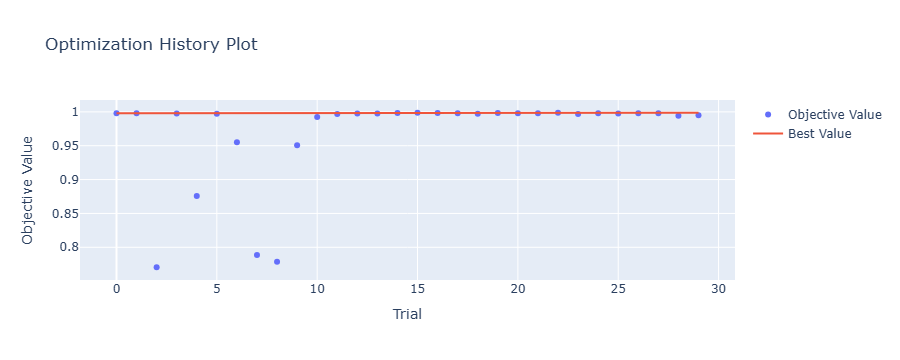

In [70]:
fig=plot_optimization_history(study)
fig.show()

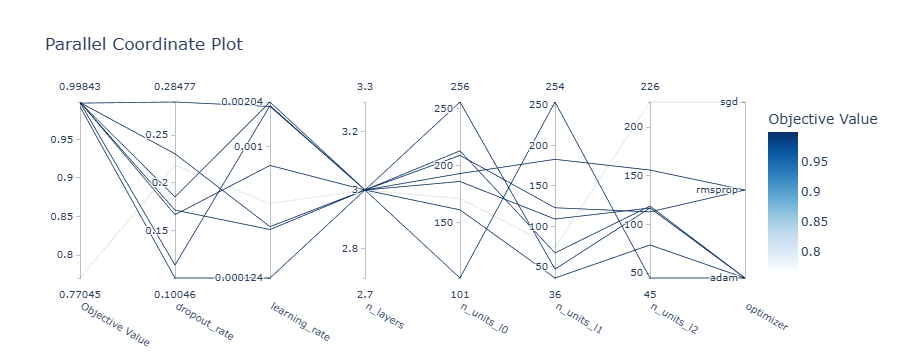

In [72]:
fig2= plot_parallel_coordinate(study)
fig2.show()

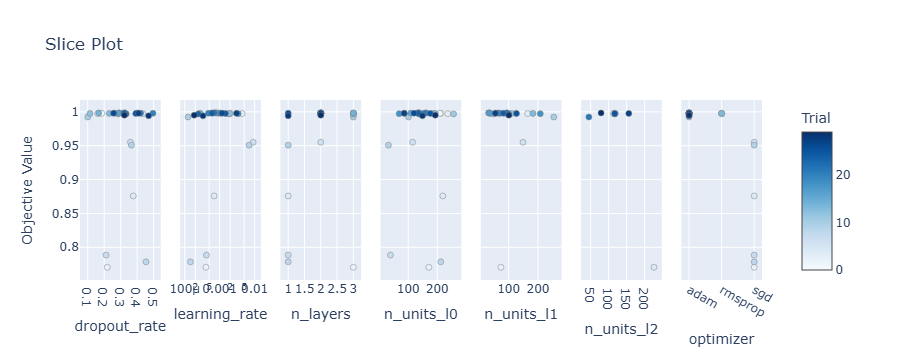

In [88]:
fig3=plot_slice(study)
fig3.show()

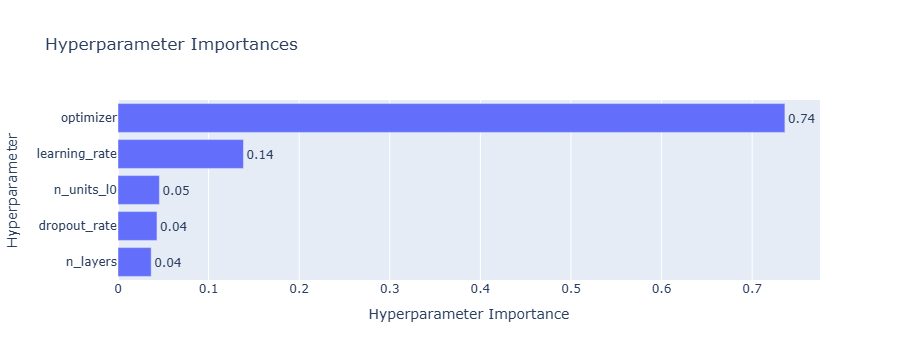

In [78]:
fig4 = plot_param_importances(study)
fig4.show()

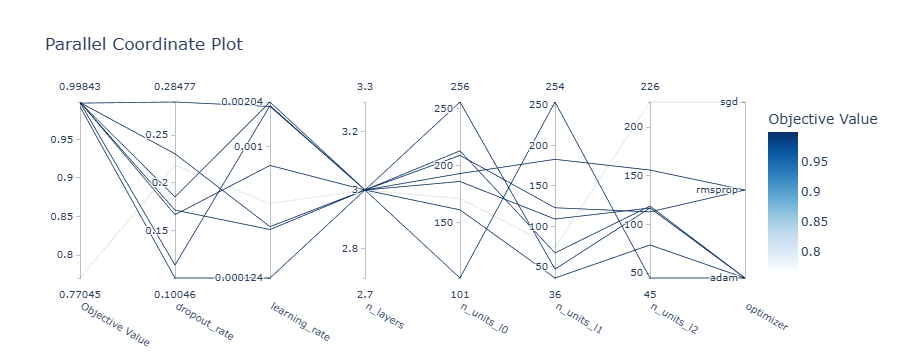

In [80]:
fig= plot_parallel_coordinate(study2)
fig.show()

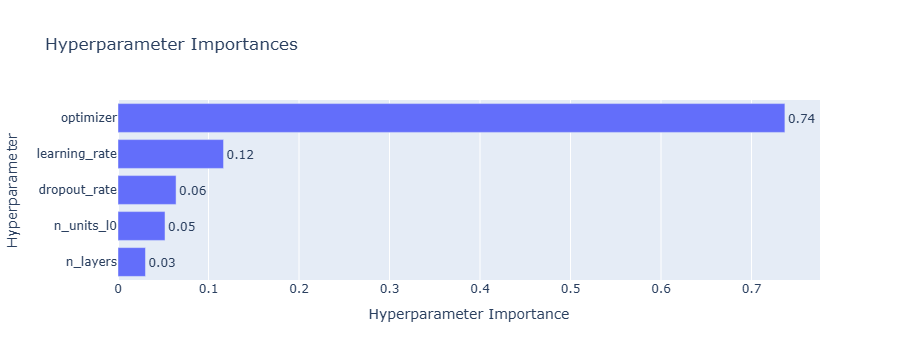

In [82]:
fig = plot_param_importances(study2)
fig.show()

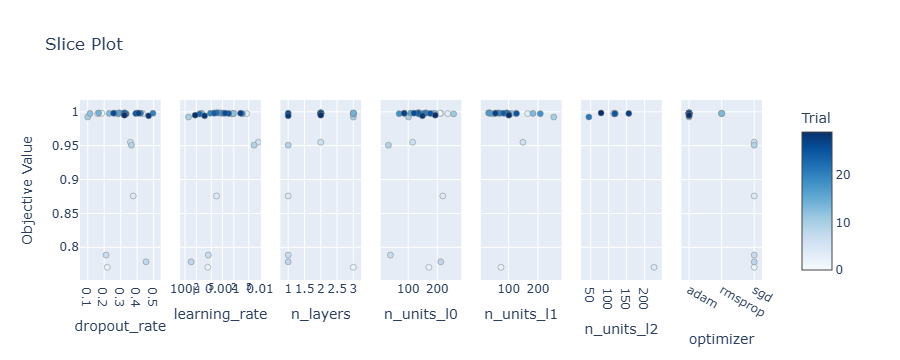

In [84]:
fig=plot_slice(study2)
fig.show()

Las gráficas se mantienen un poco en la misma sintonía, podemos tomar con más importancia las primeras ya que se hizo con 30 pruebas, evidentemente el optimizador $sgd$ no es una buena opción, el número de capas en la red no influye mucho.


Usaré el resultado del mejor modelo de la segunda prueba, usar una sola capa hace más sencillo el modelo y por tanto es menos probable el sobre ajuste, además, muy prbablemente es más rápido de entrenar y de usar.

#### Construir modelo final

- learning_rate = 0.0011237274912424564
- n_layers = 1
- dropout_rate = 0.3340405573602332
- optimizer = adam
- n_unitsl0 = 80

In [103]:
#construimos el modelo con los hiperparámetros seleccionados 
modelf = tf.keras.models.Sequential()
modelf.add(tf.keras.layers.Input(shape=(x_train.shape[1],)))
modelf.add(tf.keras.layers.Dense(80, activation='relu'))
modelf.add(tf.keras.layers.Dropout(0.3340405573602332))
modelf.add(tf.keras.layers.Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0011237274912424564)

modelf.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
modelf.summary()

#entrenamos el modelo con el conjunto de entrenamiento
history= modelf.fit(x_train,y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_test, y_test))

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_153 (Dense)               │ (None, 80)             │         6,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,401 (25.00 KB)

 Trainable params: 6,401 (25.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9305 - loss: 0.1601 - val_accuracy: 0.9743 - val_loss: 0.0703
Epoch 2/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9819 - loss: 0.0510 - val_accuracy: 0.9938 - val_loss: 0.0229
Epoch 3/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9937 - loss: 0.0206 - val_accuracy: 0.9966 - val_loss: 0.0111
Epoch 4/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9962 - loss: 0.0116 - val_accuracy: 0.9980 - val_loss: 0.0065
Epoch 5/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9973 - loss: 0.0081 - val_accuracy: 0.9984 - val_loss: 0.0050
Epoch 6/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9974 - loss: 0.0069 - val_accuracy: 0.9984 - val_loss: 0.0044
Epoch 7/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9978 - loss: 0.0061 - val_accuracy: 0.9989 - val_loss: 0.0038
Epoch 8/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9981 - loss: 0

2025/10/08 13:37:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: INVALID_PARAMETER_VALUE: Response: {'error_code': 'INVALID_PARAMETER_VALUE'}


Ahora, finalmente, evaluamos con el conjunto de validación.

In [105]:
val_loss, val_accuracy = modelf.evaluate(x_val, y_val)
print(f"Precisión final: {val_accuracy*100:.2f}%")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9991 - loss: 0.0022
Precisión final: 99.91%


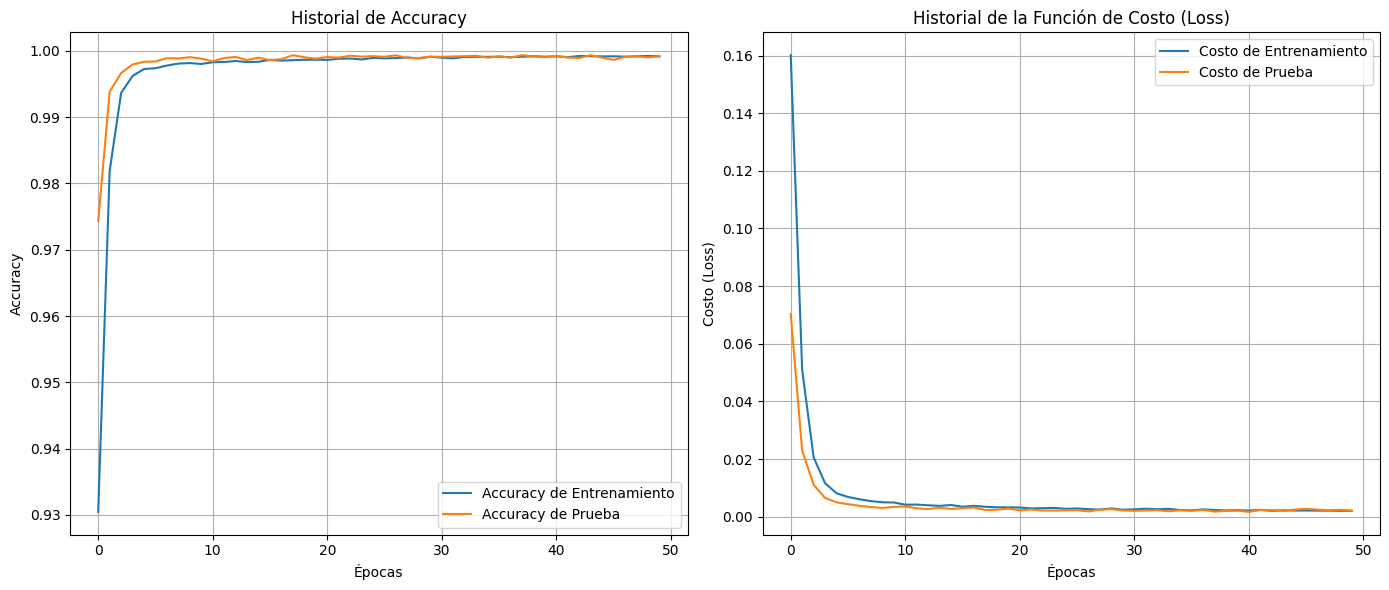

In [107]:
plt.figure(figsize=(14, 6))

# Gráfica de Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Prueba')
plt.title('Historial de Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Gráfica de la Función de Costo (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Costo de Entrenamiento')
plt.plot(history.history['val_loss'], label='Costo de Prueba')
plt.title('Historial de la Función de Costo (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Costo (Loss)')
plt.grid(True)
plt.legend()

# Ajustar el layout y mostrar las gráficas
plt.tight_layout()
plt.show()